<a href="https://colab.research.google.com/github/shoboske/wine-quality-deep-learning/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip3 install ucimlrepo scikit-learn pandas numpy matplotlib tensorflow >/dev/null 2>&1

In [2]:
from ucimlrepo import fetch_ucirepo
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf


# fetch dataset
wine_quality = fetch_ucirepo(id=186)
red_wine = wine_quality.data.original.query('color == "red"')
white_wine = wine_quality.data.original.query('color == "white"')

columns_to_drop = ['quality', 'color']

# print(wine_quality.data.features)
num_classes = 11
X_red = red_wine.drop(columns=columns_to_drop)
y_red = tf.keras.utils.to_categorical(red_wine['quality'], num_classes=num_classes)

X_white = white_wine.drop(columns=columns_to_drop)
y_white = tf.keras.utils.to_categorical(white_wine['quality'], num_classes=num_classes)


In [3]:
import matplotlib.pyplot as plt
def plot_graph(history):
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

def std_deviation_score(X, y=None):
    return np.std(X, axis=0)

In [4]:
import pandas as pd
import numpy as np
from collections import Counter
from imblearn.over_sampling import SMOTE, ADASYN

def generate_synthetic_samples(X, y, target_class, num_samples):
    """
    Generates synthetic samples for a specific target class using ADASYN.

    Args:
        X: Input features (NumPy array).
        y: Target variable (NumPy array).
        target_class: The target class to generate samples for.
        num_samples: The number of synthetic samples to generate.

    Returns:
        NumPy array: Synthetic samples for the target class.
        NumPy array: Labels for the synthetic samples.
    """

    # Subset of data for the target class
    X_target = X[y == target_class]

    # If target class is not present or has too few samples, generate samples using SMOTE
    if X_target.shape[0] < 6:  # Check if there are fewer than 6 samples for the target class (k_neighbors + 1)
        # Instead of subset use all original data to generate new samples
        # Create a temporary target variable with at least two classes for SMOTE
        # Assuming 'y' contains class labels, create a binary target:
        # 1 for the target class, 0 for all other classes

        temp_y = np.where(y == target_class, 1, 0)

        # Check if temp_y has more than one unique class before proceeding with SMOTE
        if len(np.unique(temp_y)) > 1:
            # Adjust k_neighbors if necessary based on the number of samples available
            k_neighbors = min(5, X_target.shape[0] - 1) if X_target.shape[0] > 1 else 1

            X_synthetic, y_synthetic = SMOTE(random_state=42, k_neighbors=k_neighbors).fit_resample(X, temp_y)
            X_synthetic = X_synthetic[y_synthetic == 1][:num_samples]  # select only desired number of samples from generated samples where y_synthetic is the target_class
            y_synthetic = np.full(X_synthetic.shape[0], target_class)  # Set the correct labels for the synthetic samples

        else:
            # Handle the case where the target class is the only class or absent in the data
            # You might want to skip SMOTE for this class or use a different technique.
            # For this example, I'll just return empty arrays:
            X_synthetic, y_synthetic = np.array([]).reshape(0, X.shape[1]), np.array([])

    # If target class has enough samples, use SMOTE to generate samples
    else:
        # Similar to the above, create a binary target if necessary.
        temp_y = np.where(y == target_class, 1, 0)
        if len(np.unique(temp_y)) > 1:
            X_synthetic, y_synthetic = SMOTE(random_state=42, k_neighbors=5).fit_resample(X, temp_y)
            X_synthetic = X_synthetic[y_synthetic == 1][:num_samples]
            y_synthetic = np.full(X_synthetic.shape[0], target_class)
        else:
            X_synthetic, y_synthetic = np.array([]).reshape(0, X.shape[1]), np.array([])

    return X_synthetic, y_synthetic


def oversample_with_smote(X, y, num_classes, strategy):
    """
    Oversamples the data using SMOTE with a custom strategy.

    Args:
        X: Input features (NumPy array).
        y: Target variable (NumPy array).
        num_classes: The total number of classes.
        strategy: The sampling strategy for SMOTE.

    Returns:
        NumPy array: Oversampled input features.
        NumPy array: Oversampled target variable.
    """
    smote = SMOTE(sampling_strategy=strategy, random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)
    return X_resampled, y_resampled




In [5]:
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
import concurrent.futures
import tensorflow as tf
from imblearn.over_sampling import SMOTE

X_red_train, X_red_test, y_red_train, y_red_test = train_test_split(X_red, y_red, test_size=0.09, random_state=42)
X_white_train, X_white_test, y_white_train, y_white_test = train_test_split(X_white, y_white, test_size=0.09, random_state=42)

# Create a Pipeline for feature selection and scaling
# Define the pipeline steps
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Scaling
    ('selector', SelectKBest(score_func=std_deviation_score, k=8)),
    ('pca', PCA(n_components=5))
])

# Fit and transform the pipeline on the training data (for both red and white wine)
X_red_train_processed = pipeline.fit_transform(X_red_train, y_red_train)
X_white_train_processed = pipeline.fit_transform(X_white_train, y_white_train)

# Apply SMOTE after feature processing
# Assuming num_classes = 11, and you want at least as many samples as the majority class (Adjust if necessary)

# Count the frequency of each class
red_class_counts = Counter(np.argmax(y_red_train, axis=1))
white_class_counts = Counter(np.argmax(y_white_train, axis=1))

# Find the majority class count
max_red_count = max(red_class_counts.values())
max_white_count = max(white_class_counts.values())

# Create the strategy dictionary
strategy_red = {cls: max_red_count for cls in range(3, 9)}
strategy_white = {cls: max_white_count for cls in range(3, 9)}

# Apply SMOTE to existing classes
X_red_train_resampled, y_red_train_resampled = oversample_with_smote(X_red_train_processed, np.argmax(y_red_train, axis=1), num_classes, strategy_red)
X_white_train_resampled, y_white_train_resampled = oversample_with_smote(X_white_train_processed, np.argmax(y_white_train, axis=1), num_classes, strategy_white)

# Generate synthetic samples for missing classes for red wine
for target_class in [0, 1, 2, 9, 10]:
    X_synthetic, y_synthetic = generate_synthetic_samples(X_red_train_processed, np.argmax(y_red_train, axis=1), target_class, 100)  # Generate 100 synthetic samples
    X_red_train_resampled = np.concatenate([X_red_train_resampled, X_synthetic])
    y_red_train_resampled = np.concatenate([y_red_train_resampled, y_synthetic])

# Generate synthetic samples for missing classes for white wine
for target_class in [0, 1, 2, 9, 10]:
    X_synthetic, y_synthetic = generate_synthetic_samples(X_white_train_processed, np.argmax(y_white_train, axis=1), target_class, 100)  # Generate 100 synthetic samples
    X_white_train_resampled = np.concatenate([X_white_train_resampled, X_synthetic])
    y_white_train_resampled = np.concatenate([y_white_train_resampled, y_synthetic])

# Convert resampled y back to categorical
y_red_train_resampled = tf.keras.utils.to_categorical(y_red_train_resampled, num_classes=num_classes)
y_white_train_resampled = tf.keras.utils.to_categorical(y_white_train_resampled, num_classes=num_classes)


# Transform the test data (for both red and white wine)
X_red_test_processed = pipeline.transform(X_red_test)
X_white_test_processed = pipeline.transform(X_white_test)

Red wine model training graph


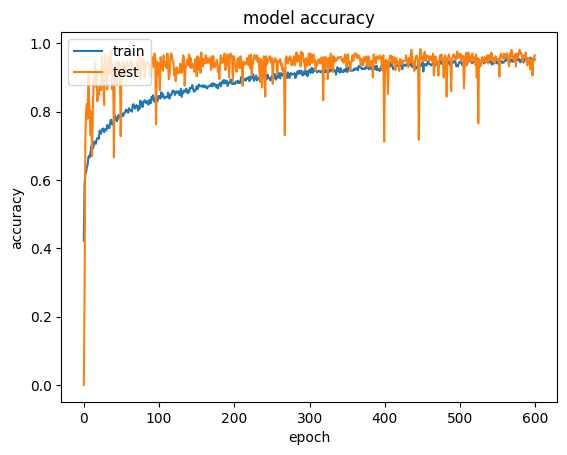

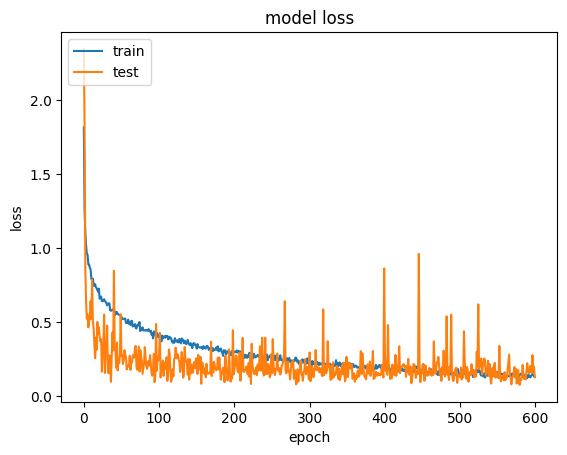

White wine model training graph


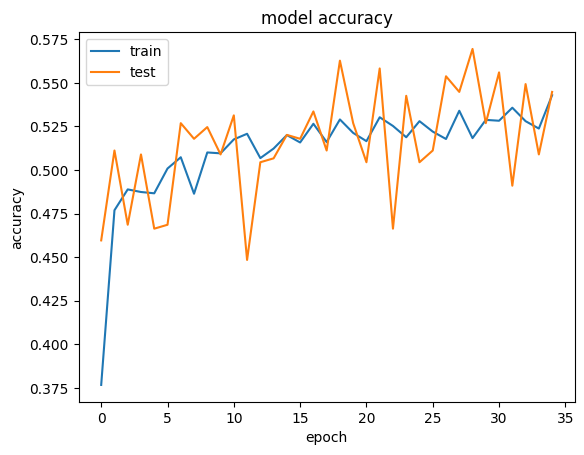

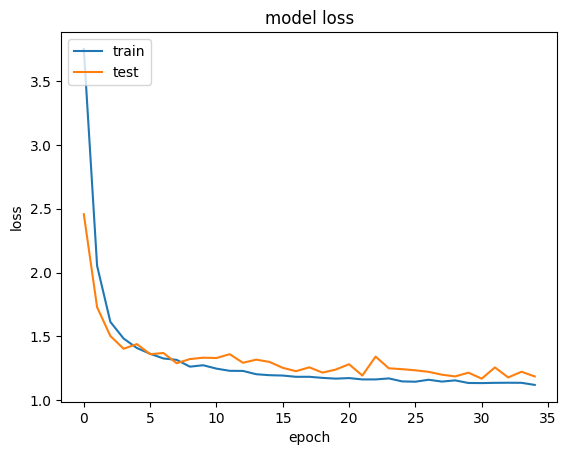

In [33]:

# Red Wine Model
red_wine_model = tf.keras.models.Sequential(
    [
        tf.keras.layers.Input(shape=X_red_train_resampled.shape[1:]),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(100, activation='tanh'),
        tf.keras.layers.Dense(73, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(73, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(73, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(73, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(73, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(73, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ],
     name="red-wine"
)

# White Wine Model (similar structure, adjust input shape)
white_wine_model = tf.keras.models.Sequential(
    [
        tf.keras.layers.Input(shape=X_white_train_resampled.shape[1:]),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(100, activation='tanh', activity_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ],
    name="white-wine"
)

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10, mode='min')
# lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
#     monitor='loss',  # Metric to monitor (e.g., validation loss)
#     factor=0.5,          # Factor to reduce learning rate by (e.g., reduce by half)
#     patience=5,          # Number of epochs with no improvement before reducing
#     min_lr=0.001      # Minimum learning rate allowed
# )

loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=False)

optimizer_red = tf.keras.optimizers.SGD(learning_rate=0.01)
optimizer_white = tf.keras.optimizers.SGD(learning_rate=0.01)

# Compile models (choose appropriate optimizer, loss, metrics)
red_wine_model.compile(optimizer=optimizer_red, loss=loss_fn, metrics=['accuracy'])
white_wine_model.compile(optimizer=optimizer_white, loss=loss_fn, metrics=['accuracy', 'mse'])

# Train the models
def train_model(model, X_train, y_train, **kwargs):
    return model.fit(X_train, y_train, **kwargs)

# Train the models concurrently using ThreadPoolExecutor
with concurrent.futures.ThreadPoolExecutor() as executor:
    # Submit the training tasks for both models
    red_wine_future = executor.submit(train_model,
                                      red_wine_model,
                                      X_red_train_resampled,
                                      y_red_train_resampled,
                                      batch_size=32, epochs=600,
                                      validation_split=0.1, validation_freq=1,
                                      callbacks=[callback], verbose=0)
    white_wine_future = executor.submit(train_model,
                                        white_wine_model,
                                        X_white_train_processed,
                                        y_white_train,
                                        batch_size=32,epochs=600,
                                        validation_split=0.1,
                                        validation_freq=1,
                                        callbacks=[callback], verbose=0)

    # Get the results (history objects)
    red_wine_history = red_wine_future.result()
    white_wine_history = white_wine_future.result()

print("Red wine model training graph")
plot_graph(red_wine_history)

print("White wine model training graph")
plot_graph(white_wine_history)

In [34]:
# Evaluate the model (you can use various metrics like accuracy, precision, recall, etc.)
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
import pandas as pd

# Predictions for red and white wine
y_red_wine_pred = red_wine_model.predict(X_red_test_processed)  # Predictions for red wine
y_white_wine_pred = white_wine_model.predict(X_white_test_processed) # Predictions for white wine

# Convert predictions to class labels (if necessary)
y_red_wine_pred_classes = np.argmax(y_red_wine_pred, axis=1)
y_white_wine_pred_classes = np.argmax(y_white_wine_pred, axis=1)

# Convert y_red_test to multiclass format to match y_red_wine_pred_classes
y_red_test_classes = np.argmax(y_red_test, axis=1)
# Convert y_white_test to multiclass format to match y_white_wine_pred_classes
y_white_test_classes = np.argmax(y_white_test, axis=1)


# Evaluate Red Wine Model
accuracy_red = accuracy_score(y_red_test_classes, y_red_wine_pred_classes)
recall_red = recall_score(y_red_test_classes, y_red_wine_pred_classes, average='weighted')
precision_red = precision_score(y_red_test_classes, y_red_wine_pred_classes, average='weighted', zero_division=0.0)
f1_red = f1_score(y_red_test_classes, y_red_wine_pred_classes, average='weighted')

# Evaluate White Wine Model
accuracy_white = accuracy_score(y_white_test_classes, y_white_wine_pred_classes)
recall_white = recall_score(y_white_test_classes, y_white_wine_pred_classes, average='weighted')
precision_white = precision_score(y_white_test_classes, y_white_wine_pred_classes, average='weighted', zero_division=0.0)
f1_white = f1_score(y_white_test_classes, y_white_wine_pred_classes, average='weighted')

# Create data for DataFrame
data = [
    [f"{red_wine_model.name} ({', '.join(map(str, [*red_wine_model.layers[0].input.shape[1:], *[layer.units for layer in red_wine_model.layers if isinstance(layer, tf.keras.layers.Dense)]]))})", accuracy_red, recall_red, precision_red, f1_red],
    [f"{white_wine_model.name} ({', '.join(map(str, [*white_wine_model.layers[0].input.shape[1:], *[layer.units for layer in white_wine_model.layers if isinstance(layer, tf.keras.layers.Dense)]]))})", accuracy_white, recall_white, precision_white, f1_white]
]

headers = ["Model", "Accuracy", "Recall", "Precision", "F1 Score"]

# print(red_wine_model.summary())
# print(white_wine_model.summary())

print(pd.DataFrame(data, None, headers))

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
                                              Model  Accuracy    Recall  \
0     red-wine (5, 100, 73, 73, 73, 73, 73, 73, 11)  0.500000  0.500000   
1  white-wine (5, 100, 128, 128, 128, 128, 128, 11)  0.505669  0.505669   

   Precision  F1 Score  
0   0.485280  0.482507  
1   0.478203  0.468530  


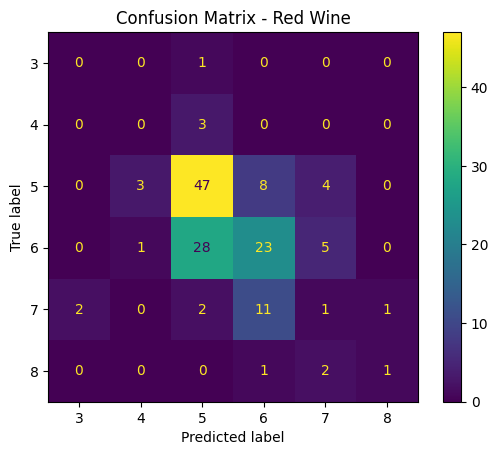

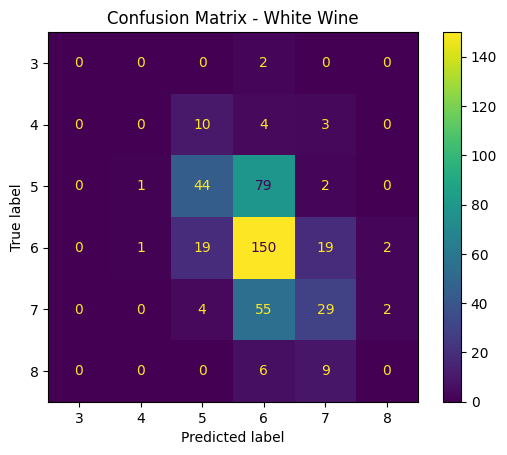

In [35]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# Generate confusion matrix for Red Wine Model
cm_red = confusion_matrix(y_red_test_classes, y_red_wine_pred_classes)

# Generate confusion matrix for White Wine Model
cm_white = confusion_matrix(y_white_test_classes, y_white_wine_pred_classes)

# Display confusion matrices
disp_red = ConfusionMatrixDisplay(confusion_matrix=cm_red, display_labels=np.unique(y_red_test_classes))
disp_red.plot(include_values=True, cmap='viridis', ax=None, xticks_rotation='horizontal')
plt.title("Confusion Matrix - Red Wine")
plt.show()
print("\n\n")

disp_white = ConfusionMatrixDisplay(confusion_matrix=cm_white, display_labels=np.unique(y_white_test_classes))
disp_white.plot(include_values=True, cmap='viridis', ax=None, xticks_rotation='horizontal')
plt.title("Confusion Matrix - White Wine")
plt.show()